# Flow

In [1]:

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import SpringRank as sr
from scipy.stats import rankdata, spearmanr

from graspologic.utils import get_lcc
from pkg.data import load_adj_meta
from pkg.plot import CLASS_COLOR_DICT, set_theme
from src.visualization import adjplot  # TODO will be in graspologic

set_theme()
print("Done")


/Users/bpedigo/miniconda3/envs/maggot-revamp/lib/python3.8/site-packages/umap/__init__.py:9: UserWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn("Tensorflow not installed; ParametricUMAP will be unavailable")
Done


In [2]:
# get the joint (union) LCC across all graphs
# this is just the LCC of the sum graph (G)
adj, meta = load_adj_meta("G")
lcc_adj, keep_inds = get_lcc(adj, return_inds=True)
# meta = meta.iloc[keep_inds]


In [3]:
graph_types = ["Gaa", "Gad", "Gda", "Gdd"]
graph_type_names = {
    "Gaa": r"$A \rightarrow A$",
    "Gad": r"$A \rightarrow D$",
    "Gda": r"$D \rightarrow A$",
    "Gdd": r"$D \rightarrow D$",
}

graphs = {}

for graph_type in graph_types:
    temp_adj, temp_meta = load_adj_meta(graph_type)
    assert (temp_meta.index.values == meta.index.values).all()
    temp_adj = temp_adj[np.ix_(keep_inds, keep_inds)]
    graphs[graph_type] = temp_adj

meta = meta.iloc[keep_inds]


In [4]:
for graph_type in graph_types:
    adj = graphs[graph_type]
    adj_lcc, inds = get_lcc(adj, return_inds=True)
    ranks = sr.get_ranks(adj_lcc)
    meta[f"{graph_type}_sr_score"] = np.nan
    meta[f"{graph_type}_sr_rank"] = np.nan
    meta.loc[meta.index[inds], f"{graph_type}_sr_score"] = ranks
    spring_rank = rankdata(ranks)
    meta.loc[meta.index[inds], f"{graph_type}_sr_rank"] = spring_rank


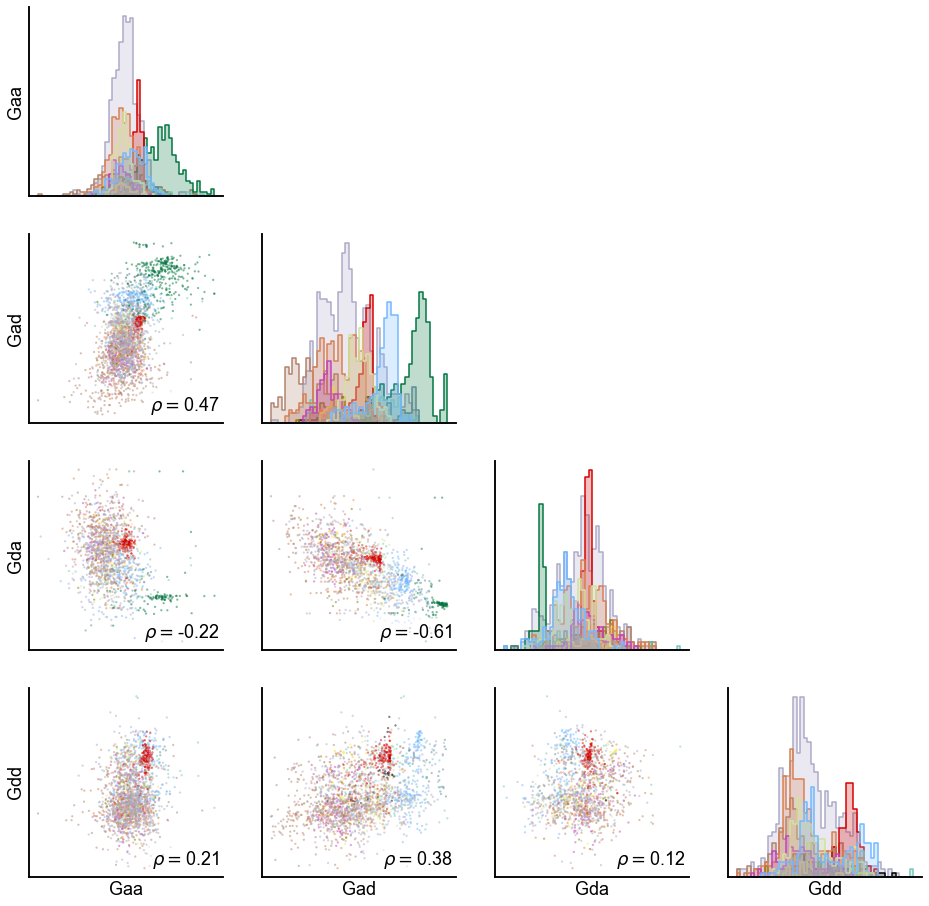

In [5]:
hue_key = "simple_class"
var = "sr_score"
n_graphs = len(graph_types)

fig, axs = plt.subplots(n_graphs, n_graphs, figsize=(16, 16))
for i, row_graph in enumerate(graph_types):
    for j, col_graph in enumerate(graph_types):

        x_var = f"{col_graph}_{var}"
        y_var = f"{row_graph}_{var}"

        spearman_corr, _ = spearmanr(meta[x_var], meta[y_var], nan_policy="omit")

        ax = axs[i, j]
        if i > j:
            sns.scatterplot(
                data=meta,
                x=x_var,
                y=y_var,
                hue=hue_key,
                palette=CLASS_COLOR_DICT,
                ax=ax,
                s=5,
                alpha=0.5,
                linewidth=0,
                legend=False,
            )
            text = ax.text(
                0.98,
                0.03,
                r"$\rho = $" + f"{spearman_corr:0.2f}",
                transform=ax.transAxes,
                ha="right",
                va="bottom",
                color="black",
            )
            text.set_bbox(dict(facecolor="white", alpha=0.6, edgecolor="w"))
        elif i == j:
            sns.histplot(
                data=meta,
                x=x_var,
                ax=ax,
                bins=50,
                element="step",
                # color="grey",
                hue=hue_key,
                palette=CLASS_COLOR_DICT,
                legend=False,
                stat="density",
                common_norm=True,
            )
        else:
            ax.axis("off")
        ax.set(xticks=[], yticks=[], xlabel="", ylabel="")
        if i == n_graphs - 1:
            ax.set(xlabel=f"{col_graph}")
        if j == 0:
            ax.set(ylabel=f"{row_graph}")
    # stashfig(f"{var}-pairwise")


In [6]:
for graph_type in graph_types:
    adj = graphs[graph_type]
    adj_lcc, inds = get_lcc(adj, return_inds=True)
    ranks = sr.get_ranks(adj_lcc)
    beta = sr.get_inverse_temperature(adj_lcc, ranks)
    print(beta)


1.114438079911836
2.038161366786986
3.4640518828635884
1.837177843715216


In [7]:
A = adj_lcc.copy()

ranks = sr.get_ranks(A)
beta = sr.get_inverse_temperature(A, ranks)


def estimate_spring_rank_P(A, ranks, beta):
    H = ranks[:, None] - ranks[None, :] - 1
    H = np.multiply(H, H)
    H *= 0.5
    P = np.exp(-beta * H)
    P *= np.mean(A) / np.mean(P)  # TODO I might be off by a constant here
    return P



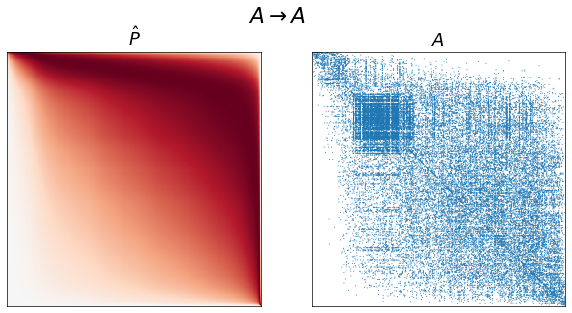

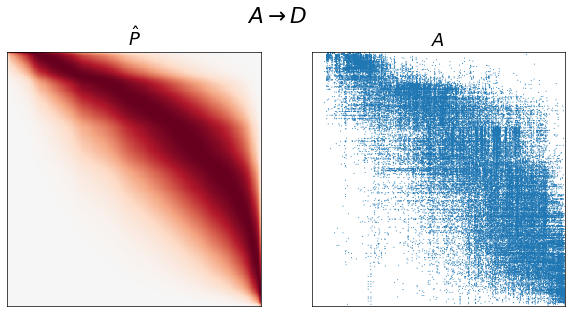

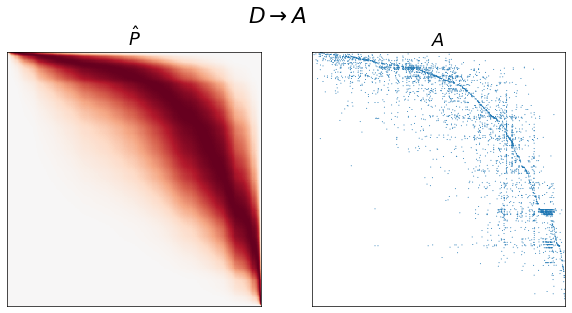

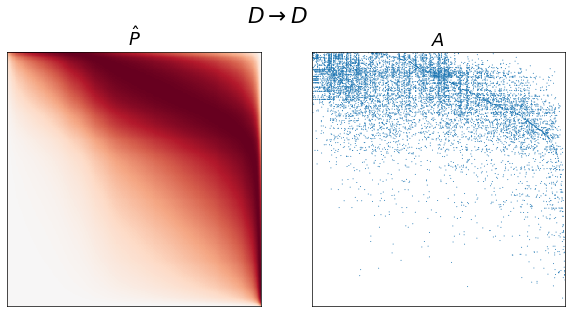

In [8]:
for graph_type in graph_types:
    adj = graphs[graph_type]
    A, inds = get_lcc(adj, return_inds=True)
    ranks = sr.get_ranks(A)
    beta = sr.get_inverse_temperature(A, ranks)
    P = estimate_spring_rank_P(A, ranks, beta)
    sort_inds = np.argsort(-ranks)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    adjplot(P[np.ix_(sort_inds, sort_inds)], ax=axs[0], cbar=False, title=r"$\hat{P}$")
    adjplot(
        A[np.ix_(sort_inds, sort_inds)],
        plot_type="scattermap",
        ax=axs[1],
        sizes=(1, 1),
        title=r"$A$",
    )
    fig.suptitle(graph_type_names[graph_type])